In [194]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from nltools.data import Brain_Data, Design_Matrix, Adjacency
import networkx as nx
from scipy import signal
from mne_connectivity import spectral_connectivity_epochs
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from itertools import cycle
from matplotlib.lines import Line2D
from scipy.fft import fft, fftfreq
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from matplotlib.animation import FuncAnimation, PillowWriter
import plotly.graph_objs as go
from functools import reduce




from functions.EpiIndex import *
from functions.Connectivity import *

Here we are going to calculate some metrics using the matrix for every band as a temporal network 


In [2]:
raw=mne.io.read_raw_fif('/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_5.fif', preload=True)
#Reading a npy file 
data_alpha = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_alpha_aec_dense.npy')
data_beta = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_beta_aec_dense.npy')
data_hgamma = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_high_gamma1_aec_dense.npy')
data_lgamma = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_low_gamma_aec_dense.npy')
data_theta = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_theta_aec_dense.npy')

data_alpha_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_alpha_aec_distance_dense.npy')
data_beta_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_beta_aec_distance_dense.npy')
data_hgamma_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_high_gamma1_aec_distance_dense.npy')
data_lgamma_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_low_gamma_aec_distance_dense.npy')
data_theta_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_theta_aec_distance_dense.npy')
# Reading the .tsv file 
xyz_loc = pd.read_csv('/home/pablo/works/dev_thesis_SEEG/data/pte_01/others/sEEG_locs_filtered.tsv', sep='\t')


#Data with other metrics
data_coh = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/SR_subseg_connectivity_data_high_freq_coh_dense.npy')[:,:,:,0]
# Assuming data is the array with shape (50, 127, 127)
for i in range(data_coh.shape[0]):
    # Extract the lower triangular part (including the diagonal)
    lower_triangular = np.tril(data_coh[i])
    
    # Mirror the lower triangular part to the upper triangular part
    data_coh[i] = lower_triangular + lower_triangular.T - np.diag(np.diag(lower_triangular))

#Make data_coh symmetric

# con_data=np.mean(data,axis=3)
raw.drop_channels(["lp'11", "lp'12", "op'12", "pi'18", "pa'12"])

Opening raw data file /home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_5.fif...
Isotrak not found
    Range : 2546688 ... 2731008 =   4974.000 ...  5334.000 secs
Ready.


/tmp/ipykernel_332025/3470177540.py:1: RuntimeWarning: This filename (/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_5.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw=mne.io.read_raw_fif('/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_5.fif', preload=True)


Reading 0 ... 184320  =      0.000 ...   360.000 secs...


Measurement date,"May 20, 2024 02:11:21 GMT"
Experimenter,Unknown
Participant,Sara
Digitized points,Not available
Good channels,122 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.15 Hz
Lowpass,134.00 Hz


In [4]:
epochs=mne.make_fixed_length_epochs(raw, duration=6, preload=True)


Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 3072 original time points ...
0 bad epochs dropped


In [5]:
#Plot the epochs in t = 30  and t = 60
epoch_30 = epochs[30]
epoch_49 = epochs[49]


In [30]:
#Crisis at the time 
t=29
data=data_lgamma_norm

crisis_mat=data[t,:,:]
significant_channels = np.argsort(np.sum(np.abs(crisis_mat), axis=1))[-10:]  # Top 5 channels

print('Significant channels:', significant_channels)
print('Significant channels names:', [ch_names[i] for i in significant_channels])

# Prepare data for all channels (blue) and significant channels (red)
all_channels_trace = go.Scatter3d(
    x=xyz_loc['r'], y=xyz_loc['a'], z=xyz_loc['s'],
    mode='markers',
    marker=dict(size=5, color='blue'),
    text=[label[3:].lower() for label in xyz_loc['label']],  # Remove "EEG" and lowercase labels
    name='All channels'
)

significant_channels_trace = go.Scatter3d(
    x=xyz_loc['r'][significant_channels], 
    y=xyz_loc['a'][significant_channels], 
    z=xyz_loc['s'][significant_channels],
    mode='markers',
    marker=dict(size=8, color='red'),
    text=[label[3:].lower() for label in xyz_loc['label'][significant_channels]],
    name='Significant channels'
)

# Create layout
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='Right (mm)'),
        yaxis=dict(title='Anterior (mm)'),
        zaxis=dict(title='Superior (mm)'),
    ),
    title='Significant channels in 3D',
    legend=dict(x=0.7, y=0.9)
)

# Create the figure and add both traces
fig = go.Figure(data=[all_channels_trace, significant_channels_trace], layout=layout)

# Show the plot
fig.show()

Significant channels: [113  90  78  91  79  81  93  80  82 111]
Significant channels names: ["pa'3", "op'8", "oc'6", "op'9", "oc'7", "oc'9", "op'11", "oc'8", "oc'10", "pa'1"]


## Topological overlap

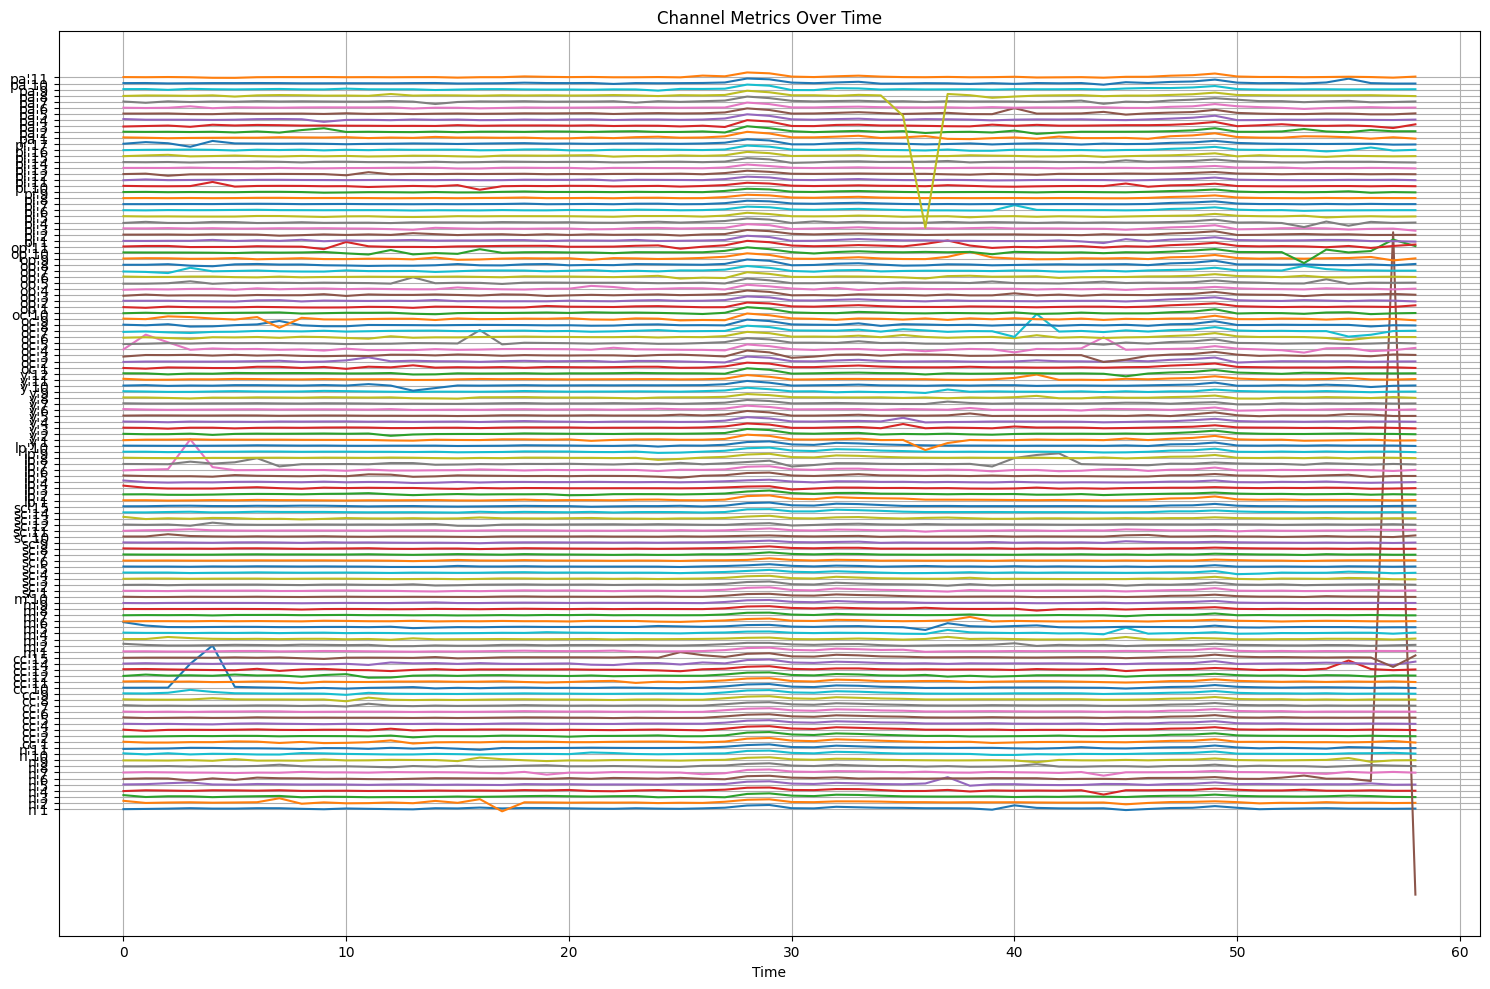

In [7]:
CIi_t=np.zeros((data.shape[0]-1,data.shape[1]))

for t in range(0, data.shape[0]-1):
    num=0
    root1=0
    root2=0
    for i in range(0, data.shape[1]):
        num=np.sum(data[t,i,:] * data[t+1,i,:])
        root1=np.sum(data[t,i,:])
        root2=np.sum(data[t+1,i,:])
        CIi_t[t,i]=num/(np.sqrt(np.abs(root1*root2)))
    
offset = 0.5 # This offset will determine the spacing between lines
ch_names=raw.info['ch_names']
rescaled_data = CIi_t + np.arange(CIi_t.shape[1]) * offset

# Create the plot
plt.figure(figsize=(15, 10))
for i in range(CIi_t.shape[1]):
    plt.plot(rescaled_data[:, i], label=ch_names[i])

# Customize the plot
plt.yticks(np.arange(len(ch_names)) * offset, ch_names)  # Set the y-ticks to the channel names
plt.xlabel('Time')
plt.title('Channel Metrics Over Time')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Average topological overlap 

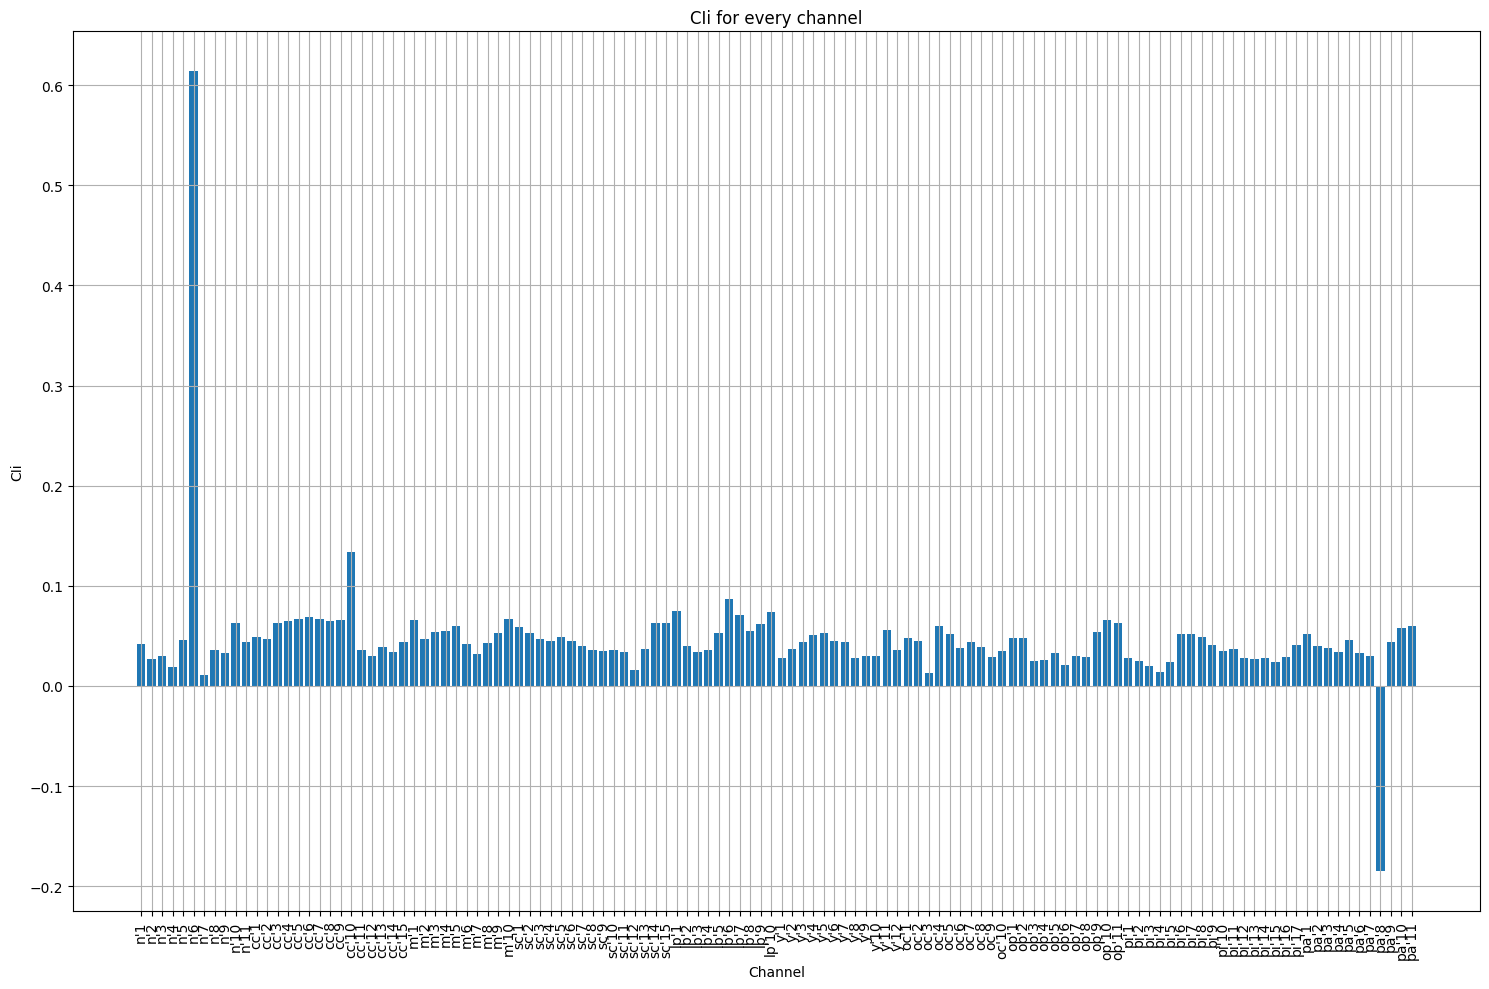

In [4]:
#Average over time for every channel 
CIi=np.mean(CIi_t,axis=0)

#Plot a hist of every channel
plt.figure(figsize=(15, 10))
plt.bar(ch_names,CIi)
plt.xlabel('Channel')
plt.xticks(rotation=90)
plt.ylabel('CIi')
plt.title('CIi for every channel')
plt.grid(True)
plt.tight_layout()
plt.show()


# Other temporal graph metrics

Volatility 
 
Calculated as $V_{t}=D(G_{t},G_{t+1})$

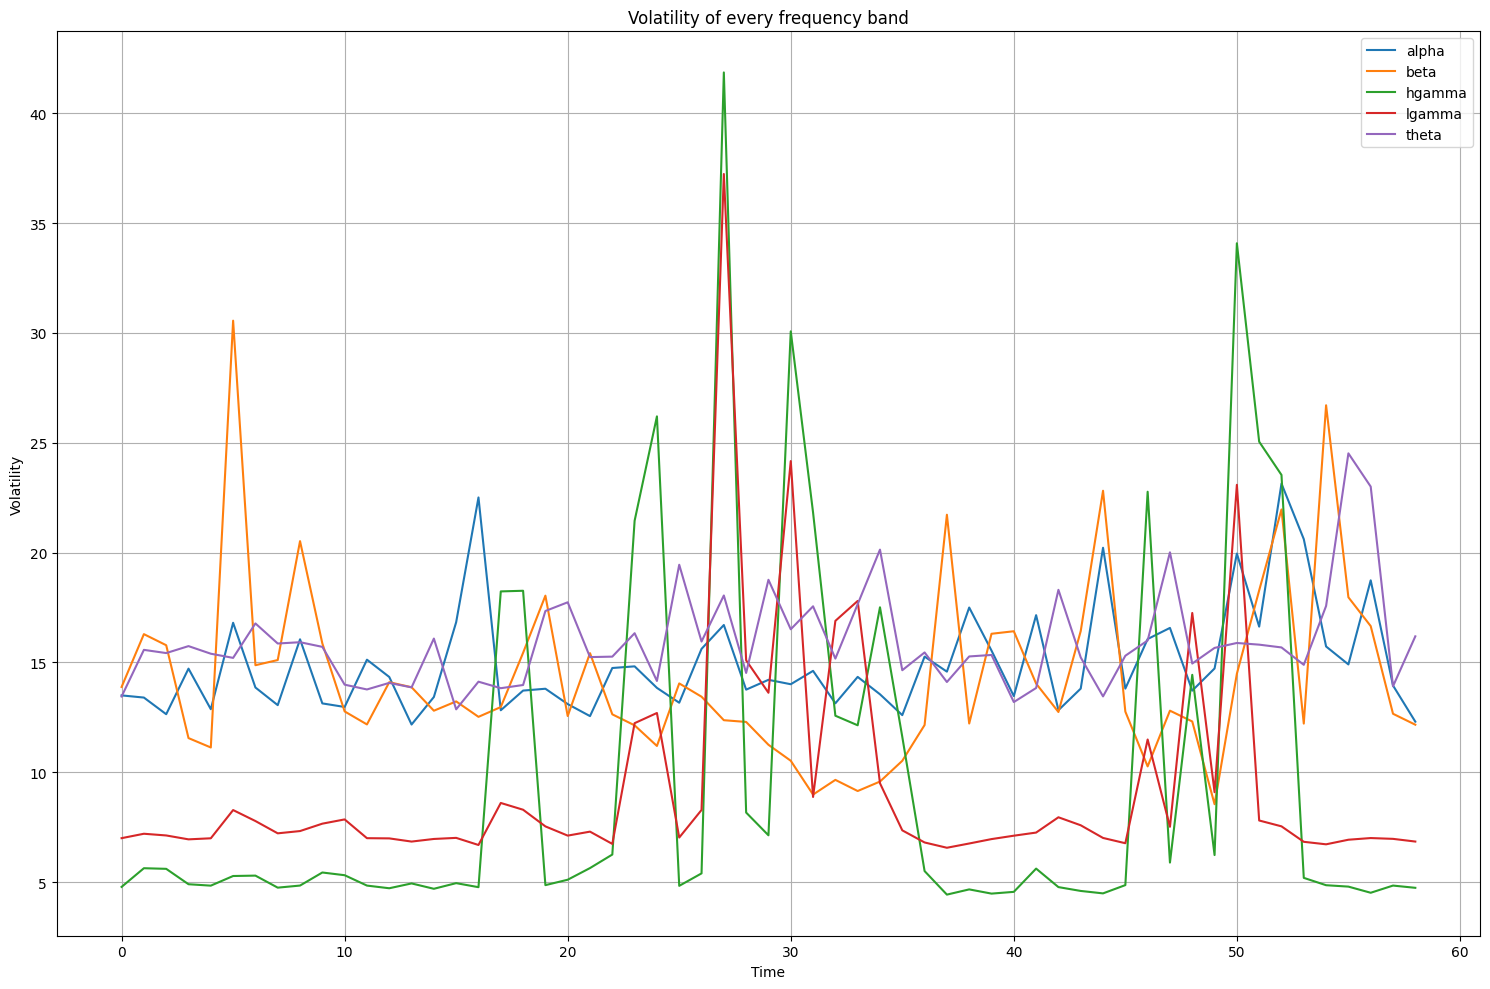

In [5]:
#Calculate the volatility of the data, as the distance between the graph in t and t+1

all_data=[data_alpha_norm,data_beta_norm,data_hgamma_norm,data_lgamma_norm,data_theta_norm]
all_data_names=['alpha','beta','hgamma','lgamma','theta']
#Volatility across time for every frequency band

volatility=np.zeros((data.shape[0]-1,len(all_data)))    
for t in range(0, data.shape[0]-1):
    for i in range(0,len(all_data)):
        temp_data=all_data[i]
        volatility[t,i]=np.linalg.norm(temp_data[t,:,:]-temp_data[t+1,:,:])

#Plot the volatility of every frequency band
plt.figure(figsize=(15, 10))
plt.plot(volatility)
plt.legend(all_data_names)
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.title('Volatility of every frequency band')
plt.grid(True)
plt.tight_layout()
plt.show()

    

# Correlation analysis

In [44]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Function to update the plot for each frame
def update(t):
    ax.clear()  # Clear previous scatter plot
    # Extract the upper triangular parts, excluding the diagonal
    #Get the SOZ channels
    inside_channels=["sc'3","sc'4","sc'5","sc'6","y'5","y'6","y'7","y'8","y'9"]
    #Get the channels outside the SOZ 
    outside_channels=[ch for ch in raw.ch_names if ch not in inside_channels]

    #Get the indices of the channels
    inside_channels_idx=[ch_names.index(ch) for ch in inside_channels]
    outside_channels_idx=[ch_names.index(ch) for ch in outside_channels]

    #From data, get the subset of matrix with the channels inside the SOZ
    data_inside=data[:,inside_channels_idx,:][:,:,inside_channels_idx]
    #From data, get the subset of matrix with the channels outside the SOZ
    data_outside=data[:,outside_channels_idx,:][:,:,outside_channels_idx]
    #From data, get the subset of matrix with relations between channels inside and outside the SOZ
    data_soz_outside=data[:,inside_channels_idx,:][:,:,outside_channels_idx]
    #From data, get the subset of matrix with relations between channels outside and inside the SOZ
    data_outside_soz=data[:,outside_channels_idx,:][:,:,inside_channels_idx]

    # Extract the upper triangular parts, excluding the diagonal
    upper_tri_1_out = data_outside[t,:,:][np.triu_indices_from(data_outside[t,:,:], k=1)]
    upper_tri_2_out = data_outside[t+1,:,:][np.triu_indices_from(data_outside[t+1,:,:], k=1)]
    upper_tri_1_inside = data_inside[t,:,:][np.triu_indices_from(data_inside[t,:,:], k=1)]
    upper_tri_2_inside = data_inside[t+1,:,:][np.triu_indices_from(data_inside[t+1,:,:], k=1)]
    upper_tri_1_soz_outside = data_soz_outside[t,:,:].flatten() 
    upper_tri_2_soz_outside = data_soz_outside[t+1,:,:].flatten()
    upper_tri_1_outside_soz = data_outside_soz[t,:,:].flatten()
    upper_tri_2_outside_soz = data_outside_soz[t+1,:,:].flatten()

    # Calculate Pearson correlation coefficient
    correlation1, p_value = pearsonr(upper_tri_1_out, upper_tri_2_out)
    correlation2, p_value = pearsonr(upper_tri_1_inside, upper_tri_2_inside)
    correlation3, p_value = pearsonr(upper_tri_1_soz_outside, upper_tri_2_soz_outside)
    correlation4, p_value = pearsonr(upper_tri_1_outside_soz, upper_tri_2_outside_soz)

    # Create scatter plot
    ax.scatter(upper_tri_1_out, upper_tri_2_out, alpha=0.7,label='Outside SOZ')
    ax.scatter(upper_tri_1_soz_outside, upper_tri_2_soz_outside, alpha=0.7,label='SOZ vs Outside')
    # plt.scatter(upper_tri_1_outside_soz, upper_tri_2_outside_soz, alpha=0.7,label='Outside vs SOZ')
    ax.scatter(upper_tri_1_inside, upper_tri_2_inside, alpha=0.7,label='Inside SOZ')
    plt.title(f'Scatter Plot of Upper Triangular Parts\nPearson Correlation: {correlation1:.2f} Outside SOZ,\n {correlation2:.2f} Inside SOZ,\n {correlation3:.2f} SOZ vs Outside')
    plt.xlabel('Matrix 1 Upper Triangular Values')
    plt.ylabel('Matrix 2 Upper Triangular Values')
    plt.legend()
    ax.grid(True)
    

# Number of time steps
time_steps = data.shape[0] - 1

# Create an animation
ani = FuncAnimation(fig, update, frames=time_steps, repeat=False)

# Save the animation as a GIF
ani.save('scatter_plot_animation_outside_SOZ.gif', writer=PillowWriter(fps=2))

plt.close()

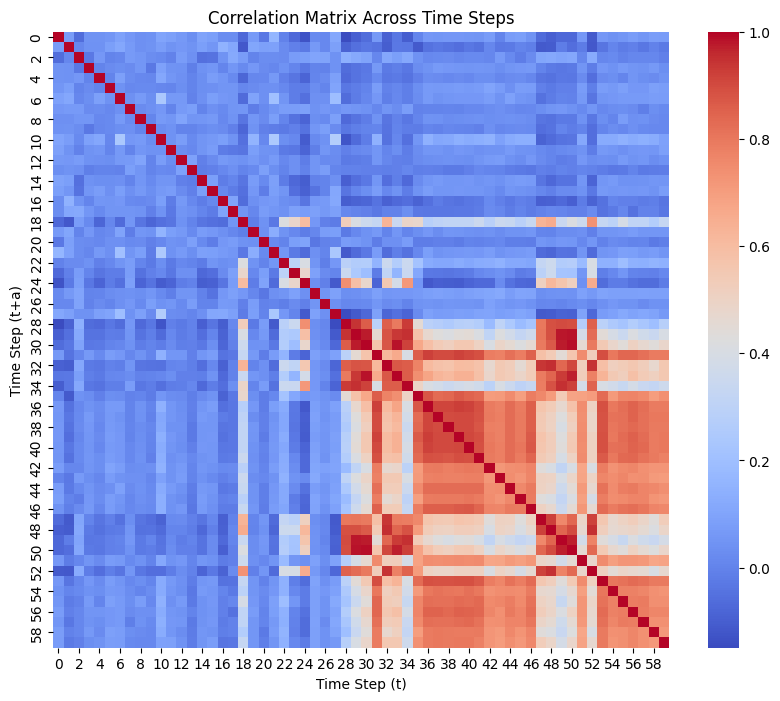

In [68]:
# Number of time steps
time_steps = data.shape[0]

# Initialize an empty correlation matrix
correlation_matrix = np.zeros((time_steps, time_steps))

# Loop through all pairs of time steps (t, t+a)
for t1 in range(time_steps):
    for t2 in range(time_steps):
        # Extract the upper triangular parts, excluding the diagonal
        upper_tri_1 = data[t1, :, :][np.triu_indices_from(data[t1, :, :], k=1)]
        upper_tri_2 = data[t2, :, :][np.triu_indices_from(data[t2, :, :], k=1)]

        # Calculate Pearson correlation coefficient
        correlation, p_value = pearsonr(upper_tri_1, upper_tri_2)

        # Store the correlation in the matrix
        correlation_matrix[t1, t2] = correlation

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix Across Time Steps")
plt.xlabel("Time Step (t)")
plt.ylabel("Time Step (t+a)")
plt.show()

## Analysis of the correlation matrix

In [24]:
#Getting the time which got a correlation higher than 0.95, ignoring the diagonal
time_high_correlation = np.where((correlation_matrix > 0.90) & (correlation_matrix < 1))
time_high_correlation = np.array(time_high_correlation)
time_high_correlation = time_high_correlation[:, time_high_correlation[0] != time_high_correlation[1]]  
time_high_correlation = time_high_correlation.T

print(f"Time steps with correlation higher than 0.95: {time_high_correlation}")

Time steps with correlation higher than 0.95: [[29 49]
 [29 50]
 [49 29]
 [50 29]]


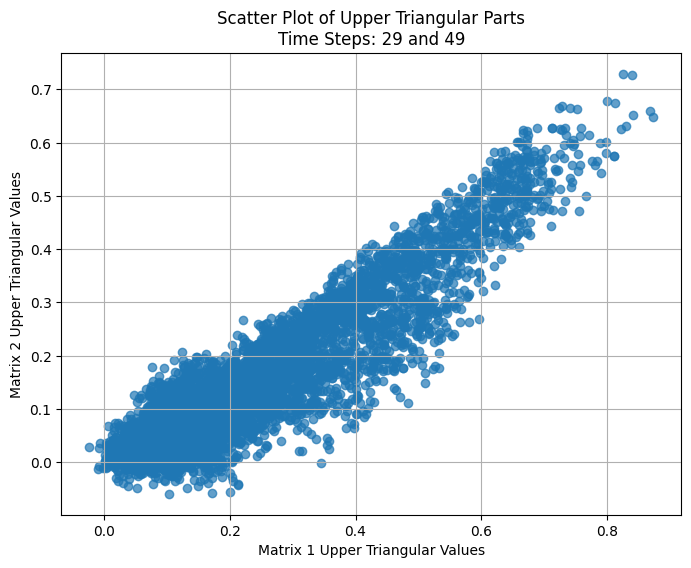

In [29]:
#plotting the matrix with the highest correlation
t1, t2 = time_high_correlation[0]
plt.figure(figsize=(8, 6))
plt.scatter(data[t1, :, :][np.triu_indices_from(data[t1, :, :], k=1)], data[t2, :, :][np.triu_indices_from(data[t2, :, :], k=1)], alpha=0.7)
plt.title(f'Scatter Plot of Upper Triangular Parts\nTime Steps: {t1} and {t2}')
plt.xlabel('Matrix 1 Upper Triangular Values')
plt.ylabel('Matrix 2 Upper Triangular Values')
plt.grid(True)
plt.show()

In [20]:
#Analize t=29 and t=30 
t1=29
t2=30

# Extract the upper triangular parts, excluding the diagonal
upper_tri_1 = data[t1, :, :][np.triu_indices_from(data[t1, :, :], k=1)]
upper_tri_2 = data[t2, :, :][np.triu_indices_from(data[t2, :, :], k=1)]
scatter=np.array([upper_tri_1,upper_tri_2]).T
#Get an array of the tuples with the names of the channels
ch_names_tup=[(ch_names[i],ch_names[j]) for i,j in zip(np.triu_indices_from(data[t1, :, :], k=1)[0],np.triu_indices_from(data[t1, :, :], k=1)[1])]


In [117]:
#We are going to calculate a kmeans clustering of the scatter plot, and then say which channels are in the same cluster
from sklearn.cluster import KMeans

# Number of clusters
n_clusters = 2

# Create a KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(scatter)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Create a DataFrame with the channel names and cluster labels
df = pd.DataFrame({'Channel Pair': ch_names_tup, 'Cluster': cluster_labels})

# Sort the DataFrame by cluster
df = df.sort_values('Cluster').reset_index(drop=True)

# Display the DataFrame
print(df)


        Channel Pair  Cluster
0         (n'1, n'2)        0
1        (m'7, pi'5)        0
2         (m'8, m'9)        0
3        (m'8, m'10)        0
4        (m'9, m'10)        0
...              ...      ...
7996   (cc'15, pi'2)        1
7997   (cc'15, pi'1)        1
7998  (cc'15, op'12)        1
7999  (cc'15, pi'12)        1
8000     (sc'4, y'1)        1

[8001 rows x 2 columns]


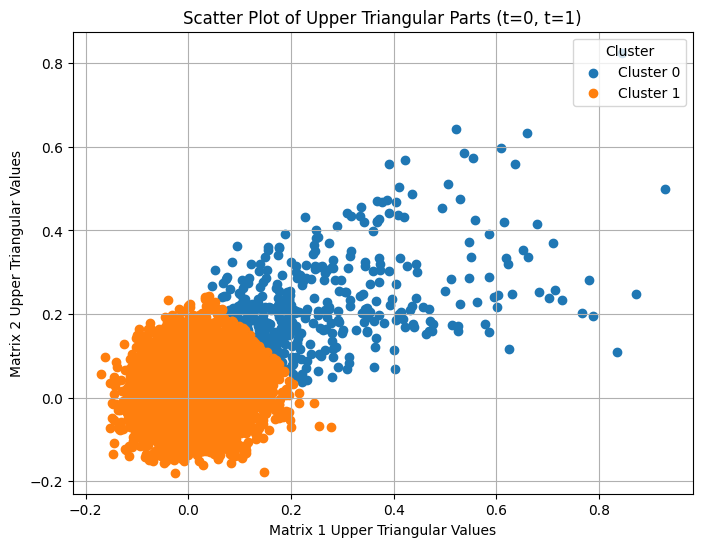

In [118]:
#Show the scatter plot with the clusters
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create a color cycle for the clusters
colors = cycle(sns.color_palette('tab10', n_clusters))

# Loop through each cluster
for cluster in range(n_clusters):
    # Get the indices of the scatter points in the cluster
    cluster_indices = np.where(cluster_labels == cluster)[0]

    # Get the color for the cluster
    color = next(colors)

    # Plot the scatter points for the cluster
    ax.scatter(scatter[cluster_indices, 0], scatter[cluster_indices, 1], label=f'Cluster {cluster}', color=color)

# Customize the plot
ax.set_title(f'Scatter Plot of Upper Triangular Parts (t={t1}, t={t2})')
ax.set_xlabel('Matrix 1 Upper Triangular Values')
ax.set_ylabel('Matrix 2 Upper Triangular Values')
ax.legend(title='Cluster', loc='upper right')
ax.grid(True)

# Show the plot
plt.show()

In [122]:
#Extract the unique values of the channels in the tuples, for the first component, and the second component of the tuple
unique_channels=np.unique(np.array(ch_names_tup).flatten())
uniques_1=np.unique(np.array(ch_names_tup)[:,0])
uniques_2=np.unique(np.array(ch_names_tup)[:,1])



In [121]:
# #Make a plot, with the channels in the same cluster in the same color
# # Create a figure and axis
# fig, ax = plt.subplots(figsize=(10, 8))

# # Create a color cycle for the clusters
# colors = cycle(sns.color_palette('tab10', n_clusters))

# # Loop through each cluster

# for cluster in range(n_clusters):
#     # Get the indices of the scatter points in the cluster
#     cluster_indices = np.where(cluster_labels == cluster)[0]

#     # Get the color for the cluster
#     color = next(colors)

#     # Loop through each channel pair in the cluster
#     for i in cluster_indices:
#         # Get the channel pair
#         channel_pair = ch_names_tup[i]

#         # Get the channel indices
#         ch1_idx = ch_names.index(channel_pair[0])
#         ch2_idx = ch_names.index(channel_pair[1])

#         # Plot the channel pair
#         ax.plot([ch1_idx, ch2_idx], [t1, t2], color=color)

# # Customize the plot
# ax.set_yticks(range(data.shape[0]))
# ax.set_yticklabels(range(data.shape[0]))
# ax.set_ylabel('Time Step')

# ax.set_xticks(range(len(ch_names)))
# ax.set_xticklabels(ch_names, rotation=90)
# ax.set_xlabel('Channel')

# ax.set_title(f'Channel Pairs in Clusters (t={t1}, t={t2})')
# ax.grid(True)

# # Create a custom legend
# legend_elements = [Line2D([0], [0], color='black', label=f'Cluster {cluster}') for cluster in range(n_clusters)]
# ax.legend(handles=legend_elements, title='Cluster', loc='upper right')

# # Show the plot
# plt.tight_layout()
# plt.show()

## Inside and outside analysis 

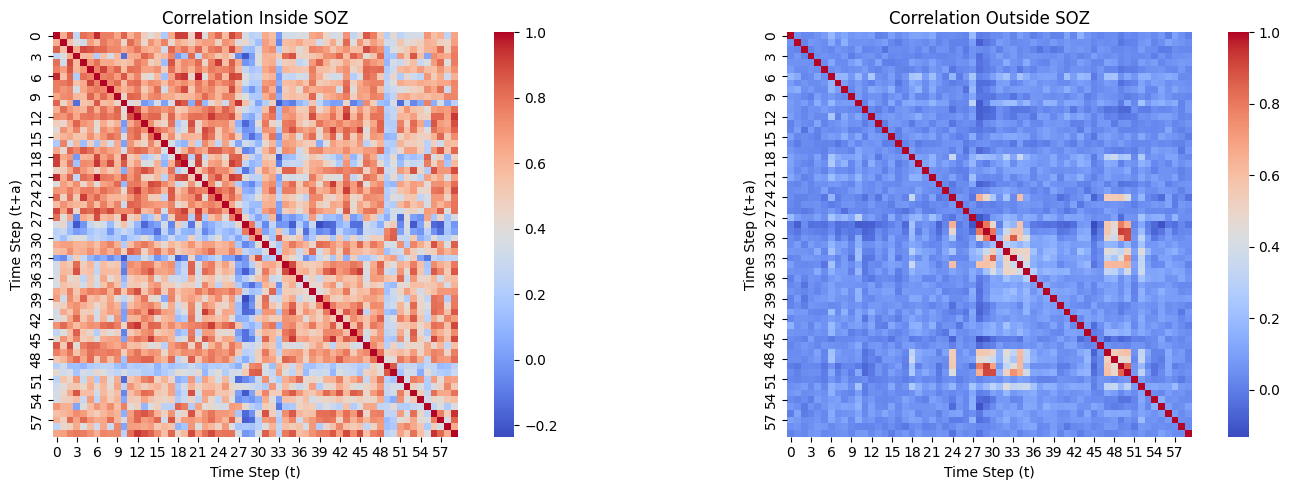

In [15]:
#For this data set, we are going to get the temporal correlation of the channels inside, outside, inside vs outside
#the SOZ
data=data_lgamma_norm
data.shape

#Get the SOZ channels
inside_channels=["sc'3","sc'4","sc'5","sc'6","y'5","y'6","y'7","y'8","y'9"]
#Get the channels outside the SOZ 
outside_channels=[ch for ch in raw.ch_names if ch not in inside_channels]

#Get the indices of the channels
inside_channels_idx=[ch_names.index(ch) for ch in inside_channels]
outside_channels_idx=[ch_names.index(ch) for ch in outside_channels]

#From data, get the subset of matrix with the channels inside the SOZ
data_inside=data[:,inside_channels_idx,:][:,:,inside_channels_idx]
#From data, get the subset of matrix with the channels outside the SOZ
data_outside=data[:,outside_channels_idx,:][:,:,outside_channels_idx]
#From data, get the subset of matrix with relations between channels inside and outside the SOZ
data_soz_outside=data[:,inside_channels_idx,:][:,:,outside_channels_idx]
#From data, get the subset of matrix with relations between channels outside and inside the SOZ
data_outside_soz=data[:,outside_channels_idx,:][:,:,inside_channels_idx]


#Get the correlation of the channels inside the SOZ
correlation_inside = np.zeros((data.shape[0], data.shape[0]))
for t1 in range(data.shape[0]):
    for t2 in range(data.shape[0]):
        upper_tri_1 = data_inside[t1, :, :][np.triu_indices_from(data_inside[t1, :, :], k=1)]
        upper_tri_2 = data_inside[t2, :, :][np.triu_indices_from(data_inside[t2, :, :], k=1)]
        correlation, _ = pearsonr(upper_tri_1, upper_tri_2)
        correlation_inside[t1, t2] = correlation

#Get the correlation of the channels outside the SOZ
correlation_outside = np.zeros((data.shape[0], data.shape[0]))
for t1 in range(data.shape[0]):
    for t2 in range(data.shape[0]):
        upper_tri_1 = data_outside[t1, :, :][np.triu_indices_from(data_outside[t1, :, :], k=1)]
        upper_tri_2 = data_outside[t2, :, :][np.triu_indices_from(data_outside[t2, :, :], k=1)]
        correlation, _ = pearsonr(upper_tri_1, upper_tri_2)
        correlation_outside[t1, t2] = correlation

#Get the correlation of the channels inside the SOZ with the channels outside the SOZ
correlation_soz_outside = np.zeros((data.shape[0], data.shape[0]))
for t1 in range(data.shape[0]):
    for t2 in range(data.shape[0]):
        upper_tri_1 = data_soz_outside[t1, :, :].flatten()
        upper_tri_2 = data_soz_outside[t2, :, :].flatten()
        correlation, _ = pearsonr(upper_tri_1, upper_tri_2)
        correlation_soz_outside[t1, t2]

#Get the correlation of the channels outside the SOZ with the channels inside the SOZ
correlation_outside_soz = np.zeros((data.shape[0], data.shape[0]))
for t1 in range(data.shape[0]):
    for t2 in range(data.shape[0]):
        upper_tri_1 = data_outside_soz[t1, :, :].flatten()
        upper_tri_2 = data_outside_soz[t2, :, :].flatten()
        correlation, _ = pearsonr(upper_tri_1, upper_tri_2)
        correlation_outside_soz[t1, t2]



#Plot the correlation matrices
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the correlation of the channels inside the SOZ
sns.heatmap(correlation_inside, fmt=".2f", cmap='coolwarm', square=True, ax=axs[0])
axs[0].set_title("Correlation Inside SOZ")
axs[0].set_xlabel("Time Step (t)")
axs[0].set_ylabel("Time Step (t+a)")

# Plot the correlation of the channels outside the SOZ
sns.heatmap(correlation_outside, fmt=".2f", cmap='coolwarm', square=True, ax=axs[1])
axs[1].set_title("Correlation Outside SOZ")
axs[1].set_xlabel("Time Step (t)")
axs[1].set_ylabel("Time Step (t+a)")

# # Plot the correlation of the channels inside the SOZ with the channels outside the SOZ
# sns.heatmap(correlation_soz_outside, fmt=".2f", cmap='coolwarm', square=True, ax=axs[1, 0])
# axs[1, 0].set_title("Correlation SOZ vs Outside")
# axs[1, 0].set_xlabel("Time Step (t)")
# axs[1, 0].set_ylabel("Time Step (t+a)")

# # Plot the correlation of the channels outside the SOZ with the channels inside the SOZ
# sns.heatmap(correlation_outside_soz, fmt=".2f", cmap='coolwarm', square=True, ax=axs[1, 1])
# axs[1, 1].set_title("Correlation Outside vs SOZ")
# axs[1, 1].set_xlabel("Time Step (t)")
# axs[1, 1].set_ylabel("Time Step (t+a)")

plt.tight_layout()
plt.show()


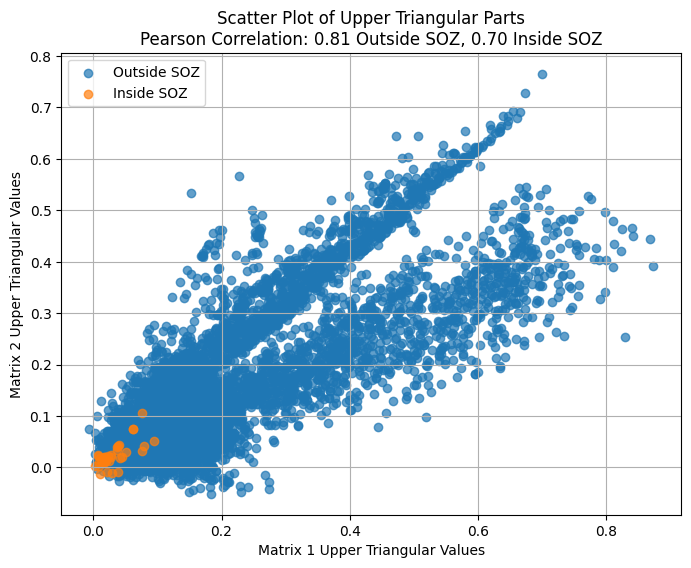

In [11]:
t=29
# Extract the upper triangular parts, excluding the diagonal
upper_tri_1_out = data_outside[t,:,:][np.triu_indices_from(data_outside[t,:,:], k=1)]
upper_tri_2_out = data_outside[t+1,:,:][np.triu_indices_from(data_outside[t+1,:,:], k=1)]
upper_tri_1_inside = data_inside[t,:,:][np.triu_indices_from(data_inside[t,:,:], k=1)]
upper_tri_2_inside = data_inside[t+1,:,:][np.triu_indices_from(data_inside[t+1,:,:], k=1)]
f='low gamma'
# Calculate Pearson correlation coefficient
correlation1, p_value = pearsonr(upper_tri_1_out, upper_tri_2_out)
correlation2, p_value = pearsonr(upper_tri_1_inside, upper_tri_2_inside)



# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(upper_tri_1_out, upper_tri_2_out, alpha=0.7,label='Outside SOZ')
plt.scatter(upper_tri_1_inside, upper_tri_2_inside, alpha=0.7,label='Inside SOZ')
plt.title(f'Scatter Plot of Upper Triangular Parts\nPearson Correlation: {correlation1:.2f} Outside SOZ, {correlation2:.2f} Inside SOZ')
plt.xlabel('Matrix 1 Upper Triangular Values')
plt.ylabel('Matrix 2 Upper Triangular Values')
plt.legend()
plt.grid(True)
plt.show()



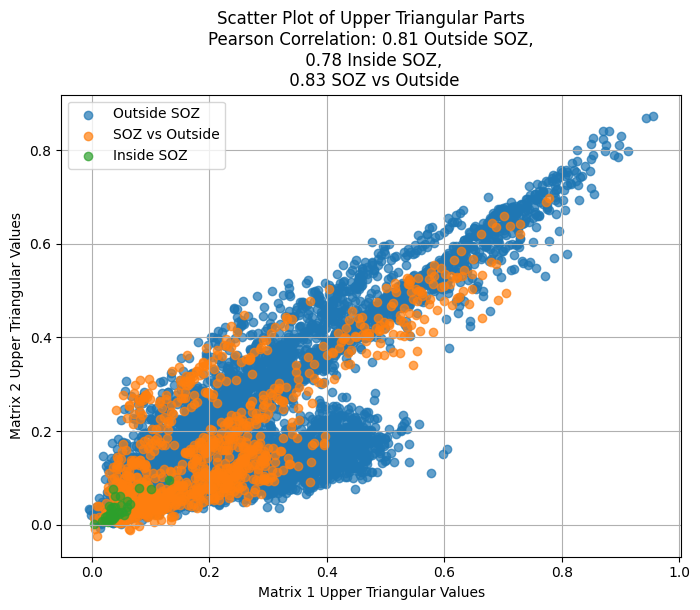

In [40]:
#Using all the data, we are plotting the correlation of all channels, and separating the channels inside and outside the SOZ
#Since every point is a relation between channels, the group of points Soz vs Soz is the same as the group of points outside vs outside
#and the group of points Soz vs outside is the same as the group of points outside vs Soz


#Get the SOZ channels
inside_channels=["sc'3","sc'4","sc'5","sc'6","y'5","y'6","y'7","y'8","y'9"]
#Get the channels outside the SOZ 
outside_channels=[ch for ch in raw.ch_names if ch not in inside_channels]

#Get the indices of the channels
inside_channels_idx=[ch_names.index(ch) for ch in inside_channels]
outside_channels_idx=[ch_names.index(ch) for ch in outside_channels]

#From data, get the subset of matrix with the channels inside the SOZ
data_inside=data[:,inside_channels_idx,:][:,:,inside_channels_idx]
#From data, get the subset of matrix with the channels outside the SOZ
data_outside=data[:,outside_channels_idx,:][:,:,outside_channels_idx]
#From data, get the subset of matrix with relations between channels inside and outside the SOZ
data_soz_outside=data[:,inside_channels_idx,:][:,:,outside_channels_idx]
#From data, get the subset of matrix with relations between channels outside and inside the SOZ
data_outside_soz=data[:,outside_channels_idx,:][:,:,inside_channels_idx]

t=28
# Extract the upper triangular parts, excluding the diagonal
upper_tri_1_out = data_outside[t,:,:][np.triu_indices_from(data_outside[t,:,:], k=1)]
upper_tri_2_out = data_outside[t+1,:,:][np.triu_indices_from(data_outside[t+1,:,:], k=1)]
upper_tri_1_inside = data_inside[t,:,:][np.triu_indices_from(data_inside[t,:,:], k=1)]
upper_tri_2_inside = data_inside[t+1,:,:][np.triu_indices_from(data_inside[t+1,:,:], k=1)]
upper_tri_1_soz_outside = data_soz_outside[t,:,:].flatten() 
upper_tri_2_soz_outside = data_soz_outside[t+1,:,:].flatten()
upper_tri_1_outside_soz = data_outside_soz[t,:,:].flatten()
upper_tri_2_outside_soz = data_outside_soz[t+1,:,:].flatten()

# Calculate Pearson correlation coefficient
correlation1, p_value = pearsonr(upper_tri_1_out, upper_tri_2_out)
correlation2, p_value = pearsonr(upper_tri_1_inside, upper_tri_2_inside)
correlation3, p_value = pearsonr(upper_tri_1_soz_outside, upper_tri_2_soz_outside)
correlation4, p_value = pearsonr(upper_tri_1_outside_soz, upper_tri_2_outside_soz)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(upper_tri_1_out, upper_tri_2_out, alpha=0.7,label='Outside SOZ')
plt.scatter(upper_tri_1_soz_outside, upper_tri_2_soz_outside, alpha=0.7,label='SOZ vs Outside')
# plt.scatter(upper_tri_1_outside_soz, upper_tri_2_outside_soz, alpha=0.7,label='Outside vs SOZ')
plt.scatter(upper_tri_1_inside, upper_tri_2_inside, alpha=0.7,label='Inside SOZ')
plt.title(f'Scatter Plot of Upper Triangular Parts\nPearson Correlation: {correlation1:.2f} Outside SOZ,\n {correlation2:.2f} Inside SOZ,\n {correlation3:.2f} SOZ vs Outside')
plt.xlabel('Matrix 1 Upper Triangular Values')
plt.ylabel('Matrix 2 Upper Triangular Values')
plt.legend()
plt.grid(True)
plt.show()


## Anterior posterior

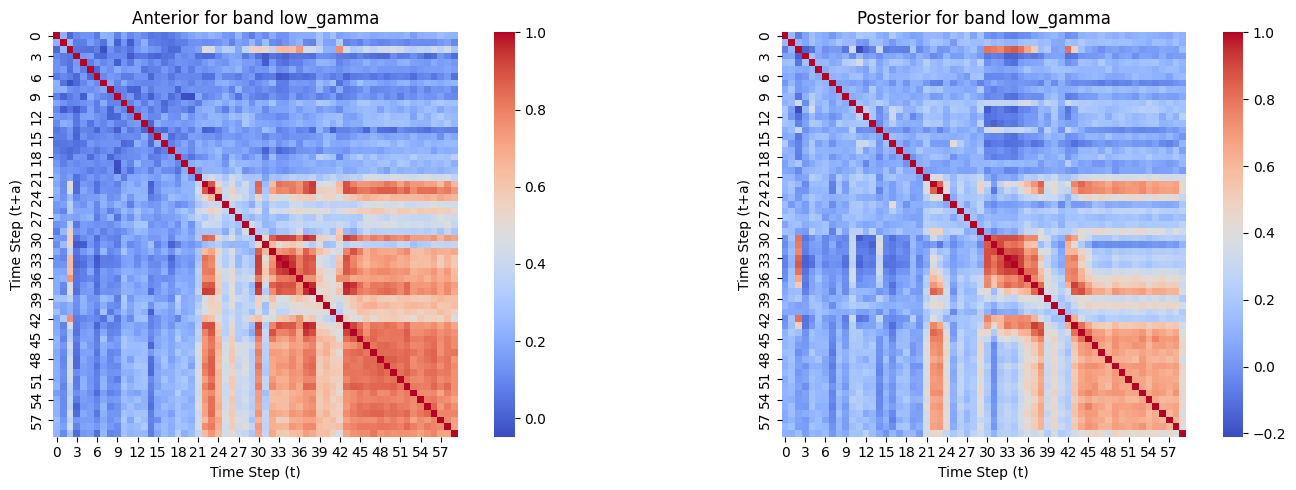

In [25]:
#For this data set, we are going to get the temporal correlation of the channels inside, outside, inside vs outside
#the SOZ
data=data_lgamma_norm
band='low_gamma'

#Get the SOZ channels
anterior_channels=["n'1",
 "n'2",
 "n'3",
 "n'4",
 "n'5",
 "n'6",
 "n'7",
 "n'8",
 "n'9",
 "n'10",
 "n'11",
 "cc'1",
 "cc'2",
 "cc'3",
 "cc'4",
 "cc'5",
 "cc'6",
 "cc'7",
 "cc'8",
 "cc'9",
 "cc'10",
 "cc'11",
 "cc'12",
 "cc'13",
 "cc'14",
 "cc'15",
  "oc'1",
 "oc'2",
 "oc'3",
 "oc'4",
 "oc'5",
 "oc'6",
 "oc'7",
 "oc'8",
 "oc'9",
 "oc'10",
 "op'1",
 "op'2",
 "op'3",
 "op'4",
 "op'5",
 "op'6",
 "op'7",
 "op'8",
 "op'9",
 "op'10",
 "op'11"
 ]
#Get the channels outside the SOZ 
posterior_channels=[ch for ch in raw.ch_names if ch not in anterior_channels]

#Get the indices of the channels
anterior_channels_idx=[ch_names.index(ch) for ch in anterior_channels]
posterior_channels_idx=[ch_names.index(ch) for ch in posterior_channels]

#From data, get the subset of matrix with the channels inside the SOZ
data_anterior=data[:,anterior_channels_idx,:][:,:,anterior_channels_idx]
#From data, get the subset of matrix with the channels outside the SOZ
data_posterior=data[:,posterior_channels_idx,:][:,:,posterior_channels_idx]

#Get the correlation of the channels inside the SOZ
correlation_anterior = np.zeros((data.shape[0], data.shape[0]))
for t1 in range(data.shape[0]):
    for t2 in range(data.shape[0]):
        upper_tri_1 = data_anterior[t1, :, :][np.triu_indices_from(data_anterior[t1, :, :], k=1)]
        upper_tri_2 = data_anterior[t2, :, :][np.triu_indices_from(data_anterior[t2, :, :], k=1)]
        correlation, _ = pearsonr(upper_tri_1, upper_tri_2)
        correlation_anterior[t1, t2] = correlation

#Get the correlation of the channels outside the SOZ
correlation_posterior = np.zeros((data.shape[0], data.shape[0]))
for t1 in range(data.shape[0]):
    for t2 in range(data.shape[0]):
        upper_tri_1 = data_posterior[t1, :, :][np.triu_indices_from(data_posterior[t1, :, :], k=1)]
        upper_tri_2 = data_posterior[t2, :, :][np.triu_indices_from(data_posterior[t2, :, :], k=1)]
        correlation, _ = pearsonr(upper_tri_1, upper_tri_2)
        correlation_posterior[t1, t2] = correlation



#Plot the correlation matrices
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(correlation_anterior, fmt=".2f", cmap='coolwarm', square=True, ax=axs[0])
axs[0].set_title(f"Anterior for band {band}")
axs[0].set_xlabel("Time Step (t)")
axs[0].set_ylabel("Time Step (t+a)")

sns.heatmap(correlation_posterior, fmt=".2f", cmap='coolwarm', square=True, ax=axs[1])
axs[1].set_title(f"Posterior for band {band}")
axs[1].set_xlabel("Time Step (t)")
axs[1].set_ylabel("Time Step (t+a)")
plt.tight_layout()
plt.show()


#  New task for finding crisis

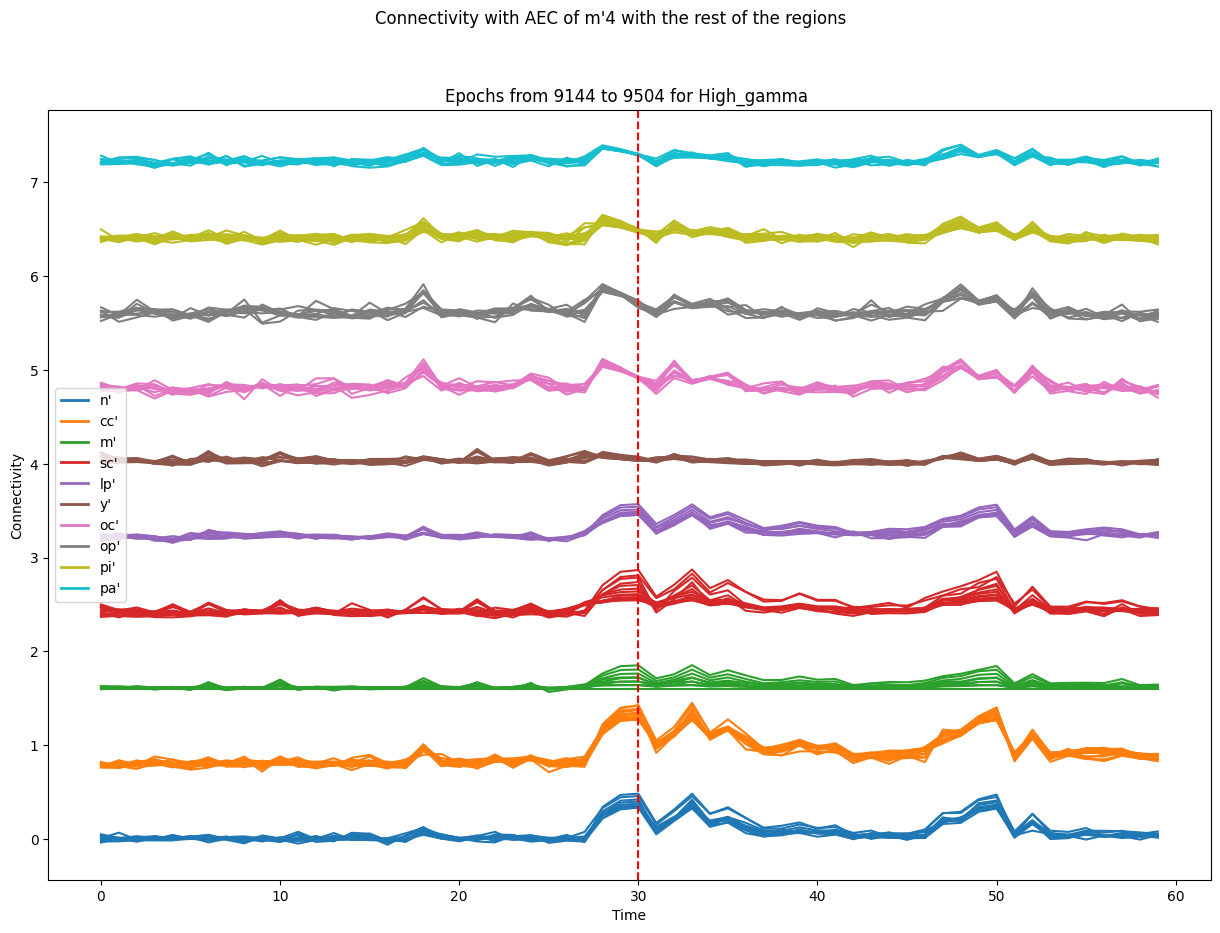

In [32]:
data=data_hgamma_norm
band='High_gamma'


total_epochs=data.shape[0]
real_time_crisis=9324
t_0=9144
t_1=9504
window_size=(t_1-t_0)/total_epochs
#Calculate the epoch of the crisis
crisis_epoch=int((real_time_crisis-t_0)/window_size)


# Make sure the matrix is symmetric
#If not, make it symmetric using the lower triangle
Connectivity_matrixes = data
N_mat=Connectivity_matrixes.shape[0]
for i in range(N_mat):
    if not np.allclose(Connectivity_matrixes[i,:,:], Connectivity_matrixes[i,:,:].T, atol=1e-8):
        Connectivity_matrixes[i,:,:] = np.tril(Connectivity_matrixes[i,:,:]) + np.tril(Connectivity_matrixes[i,:,:], -1).T
    else:
        continue


#Now, using the index of every channel, we are going ton generate the corresponding plots for every region
# Get the matrixes which consider the interested channel, e.g. the channel sc'1, 
# and the rest of the channels
#First, get all the rows, for the 150 matrixes
channel_name="m'4"
method="AEC"
# channel_name="CC01"
channel_index=ch_names.index(channel_name)
#Get the rows
rows=Connectivity_matrixes[:,channel_index,:]
regions=["n'","cc'","m'","sc'","lp'","y'","oc'","op'","pi'","pa'"]
# regions=[ 'OF', 'CR', 'CA', 'CC', 'SC', 'OP', 'IP', 'PM', 'SA', 'CP', 'PA', 'I', 'B', 'C']
#Get the index of every region checking if the regions is in the name of the channel
regions_index=[]
for region in regions:
    for i in range(len(ch_names)):
        if region in ch_names[i]:
            regions_index.append(i)
            break

#Generate labels for the regions
labels=[]
for i in ch_names:
    for region in regions:
        if region in i:
            labels.append(region)
            break 


color_cycle = cycle(plt.cm.tab10.colors)  # Cycle through a colormap
colors = {label: next(color_cycle) for label in regions}

# Plot each group of channels
plt.figure(figsize=(15, 10))

# Offset step to separate different label groups on the y-axis
offset_step = 0.8
current_offset = 0

for label in regions:
    indices = [i for i, l in enumerate(labels) if l == label]
    for i in indices:
        plt.plot(rows[:, i] + current_offset, label=f'{labels[i]} (Channel {i})', color=colors[label])
    current_offset += offset_step

# Create custom legend handles
legend_handles = [Line2D([0], [0], color=colors[label], lw=2, label=label) for label in regions]

#plot a vertical dotted line in the crisis epoch
plt.axvline(x=crisis_epoch, color='r', linestyle='--')
# Add the custom legend to the plot
plt.legend(handles=legend_handles)
plt.suptitle(f'Connectivity with {method} of {channel_name} with the rest of the regions')
#Put a subtitle
plt.title(f'Epochs from {t_0} to {t_1} for {band} ')
plt.xlabel('Time')
plt.ylabel('Connectivity')
plt.show()

In [ ]:
#The steps are the next:
#1. get the correlation matrixes at a temporal level of every channel with the rest of the channels, in t. 
#2. Using a threshold, get the times where the correlation is higher than the threshold, for every channel, and then get 
#A subset of times. 
#3. Using a reference channel: 
#   3.1 Get the connectivity at the times where the correlation is higher than the threshold
#   3.2 For this reference channel, get the  derivative of the connectivity, and then get a group of channels where 
#   the derivativbe is positive, and negative. 

In [252]:
#Step 1
#Get the correlation matrixes at a temporal level of every channel with the rest of the channels, in t.

correlation_matrixes=np.zeros((data.shape[0],data.shape[0],data.shape[1]))
for i  in range(data.shape[1]):
    for t1 in range(data.shape[0]):
        for t2 in range(data.shape[0]):
            set1=data[t1,i,:]
            set2=data[t2,i,:]
            correlation_matrixes[t1,t2,i]=np.corrcoef(set1,set2)[0,1]

            
#Step 2
#Using a threshold, get the times where the correlation is higher than the threshold, for every channel, and then get
#A subset of times.
threshold=0.95
times_high_correlation=[]
for i in range(correlation_matrixes.shape[2]):
    #Getting the time which got a correlation higher than 0.95, ignoring the diagonal
    time_high_correlation = np.where((correlation_matrixes[:,:,i] > threshold) & (correlation_matrixes[:,:,i] < 1))
    time_high_correlation = np.array(time_high_correlation)
    time_high_correlation = time_high_correlation[:, time_high_correlation[0] != time_high_correlation[1]]  
    time_high_correlation = time_high_correlation.T
    times_high_correlation.append(time_high_correlation)

#Intersect the times where the correlation is higher than the threshold to get a general time 
total=[]
for i in range(len(times_high_correlation)):
    for j in range(len(times_high_correlation[i])):
        a , b = times_high_correlation[i][j]
        total.append((a,b))

important_times=list(set(total))
#Only keeop the times which are consecutives and ordered
important_times_consecutives=[]
for i in range(len(important_times)):
    if important_times[i][0]+1==important_times[i][1]:
        important_times_consecutives.append(important_times[i])


In [251]:
# t=important_times_consecutives[0]
# ar1=reference_channel_data[t[0],:]
# ar2=reference_channel_data[t[1],:]
# dif=ar2-ar1
# #Group the channels in positive, negative and zero derivative
# positive_derivative=[np.where(dif>0)[0]]
# negative_derivative=[np.where(dif<0)[0]]
# zero_derivative=[np.where(dif==0)[0]]

# #Plot one of top of the other
# plt.figure(figsize=(15, 10))
# plt.plot(ar1,label='t1')
# plt.plot(ar2,label='t2')
# plt.plot(dif,label='dif')
# plt.legend()
# plt.title(f'Connectivity of {reference_channel} at time {t[0]} and {t[1]}')
# plt.xlabel('Channel')
# plt.ylabel('Connectivity')
# plt.grid(True)
# plt.show()

In [218]:
# #Step 3
# #Get the slice of the data for a reference channel
# reference_channel="m'4"
# reference_channel_index=ch_names.index(reference_channel)
# reference_channel_data=data[:,reference_channel_index,:]

# positive_derivative_all=[]
# negative_derivative_all=[]
# zero_derivative_all=[]


# for t in important_times_consecutives[:]:
#     #Get the connectivity at the times where the correlation is higher than the threshold
#     ar1=reference_channel_data[t[0],:]
#     ar2=reference_channel_data[t[1],:]
#     diff=ar2-ar1
#     #Group the channels in positive, negative and zero derivative
#     positive_derivative=np.where(diff>0)[0]
#     negative_derivative=np.where(diff<0)[0]
#     zero_derivative=np.where(diff==0)[0]

#     positive_derivative_all.append(positive_derivative)
#     negative_derivative_all.append(negative_derivative)
#     zero_derivative_all.append(zero_derivative)

# intersection_pos=reduce(np.intersect1d,positive_derivative_all)
# intersection_neg=reduce(np.intersect1d,negative_derivative_all)
# intersection_zero=reduce(np.intersect1d,zero_derivative_all)

# pos_names=[]
# neg_names=[]
# zero_names=[]

# for idx in intersection_pos:
#     pos_names.append(ch_names[idx])
    
# for idx in intersection_neg:
#     neg_names.append(ch_names[idx])
    
# for idx in intersection_zero:
#     zero_names.append(ch_names[idx])

# print(f'The intersection of channels with possitive derivative for all times is {pos_names}')
# print(f'The intersection of channels with possitive derivative for all times is {neg_names}')
# print(f'The intersection of channels with possitive derivative for all times is {zero_names}')


The intersection of channels with possitive derivative for all times is []
The intersection of channels with possitive derivative for all times is []
The intersection of channels with possitive derivative for all times is ["m'4"]


In [271]:
important_times_consecutives=[(28,29),(29,30)]

In [272]:
#Step 3 generalized

pos_dict={}
neg_dict={}
zero_dict={}
for ch in ch_names:
    reference_channel=ch
    reference_channel_index=ch_names.index(reference_channel)
    reference_channel_data=data[:,reference_channel_index,:]

    positive_derivative_all=[]
    negative_derivative_all=[]
    zero_derivative_all=[]


    for t in important_times_consecutives[:]:
        #Get the connectivity at the times where the correlation is higher than the threshold
        ar1=reference_channel_data[t[0],:]
        ar2=reference_channel_data[t[1],:]
        diff=ar2-ar1
        #Group the channels in positive, negative and zero derivative
        positive_derivative=np.where(diff>0)[0]
        negative_derivative=np.where(diff<0)[0]
        zero_derivative=np.where(diff==0)[0]

        positive_derivative_all.append(positive_derivative)
        negative_derivative_all.append(negative_derivative)
        zero_derivative_all.append(zero_derivative)

    intersection_pos=reduce(np.intersect1d,positive_derivative_all)
    intersection_neg=reduce(np.intersect1d,negative_derivative_all)
    intersection_zero=reduce(np.intersect1d,zero_derivative_all)

    pos_names=[]
    neg_names=[]
    zero_names=[]

    for idx in intersection_pos:
        pos_names.append(ch_names[idx])
        
    for idx in intersection_neg:
        neg_names.append(ch_names[idx])
        
    for idx in intersection_zero:
        zero_names.append(ch_names[idx])
    
    pos_dict[ch]=pos_names
    neg_dict[ch]=neg_names
    zero_dict[ch]=zero_names

    print(f'The intersection of channels with possitive derivative for all times at {ch} is {pos_names}')
    print(f'The intersection of channels with negative derivative for all times is {ch} is {neg_names}')
    print(f'The intersection of channels with zero derivative for all times is {ch} is {zero_names}')


The intersection of channels with possitive derivative for all times at n'1 is ["n'2", "n'3", "n'4", "n'5", "n'6", "n'7", "n'8", "n'9", "n'10", "n'11", "cc'1", "cc'2", "cc'3", "cc'4", "cc'5", "cc'6", "cc'7", "cc'8", "cc'9", "cc'10", "cc'11", "cc'12", "cc'13", "cc'14", "cc'15", "m'1", "m'2", "m'3", "m'4", "m'5", "m'6", "m'7", "m'8", "m'9", "m'10", "sc'1", "sc'2", "sc'3", "sc'4", "sc'5", "sc'6", "sc'7", "sc'8", "sc'9", "sc'10", "sc'11", "sc'12", "sc'13", "sc'14", "sc'15", "lp'1", "lp'2", "lp'3", "lp'4", "lp'5", "lp'6", "lp'7", "lp'8", "lp'9", "lp'10"]
The intersection of channels with negative derivative for all times is n'1 is ["y'1", "y'2", "y'3", "y'4", "y'5", "y'6", "y'7", "y'8", "y'9", "y'10", "y'11", "y'12", "oc'1", "oc'2", "oc'3", "oc'4", "oc'5", "oc'6", "oc'7", "oc'8", "oc'9", "oc'10", "op'1", "op'2", "op'3", "op'4", "op'5", "op'6", "op'7", "op'8", "op'9", "op'10", "op'11", "pi'1", "pi'2", "pi'3", "pi'4", "pi'5", "pi'6", "pi'7", "pi'8", "pi'9", "pi'10", "pi'11", "pi'12", "pi'13",

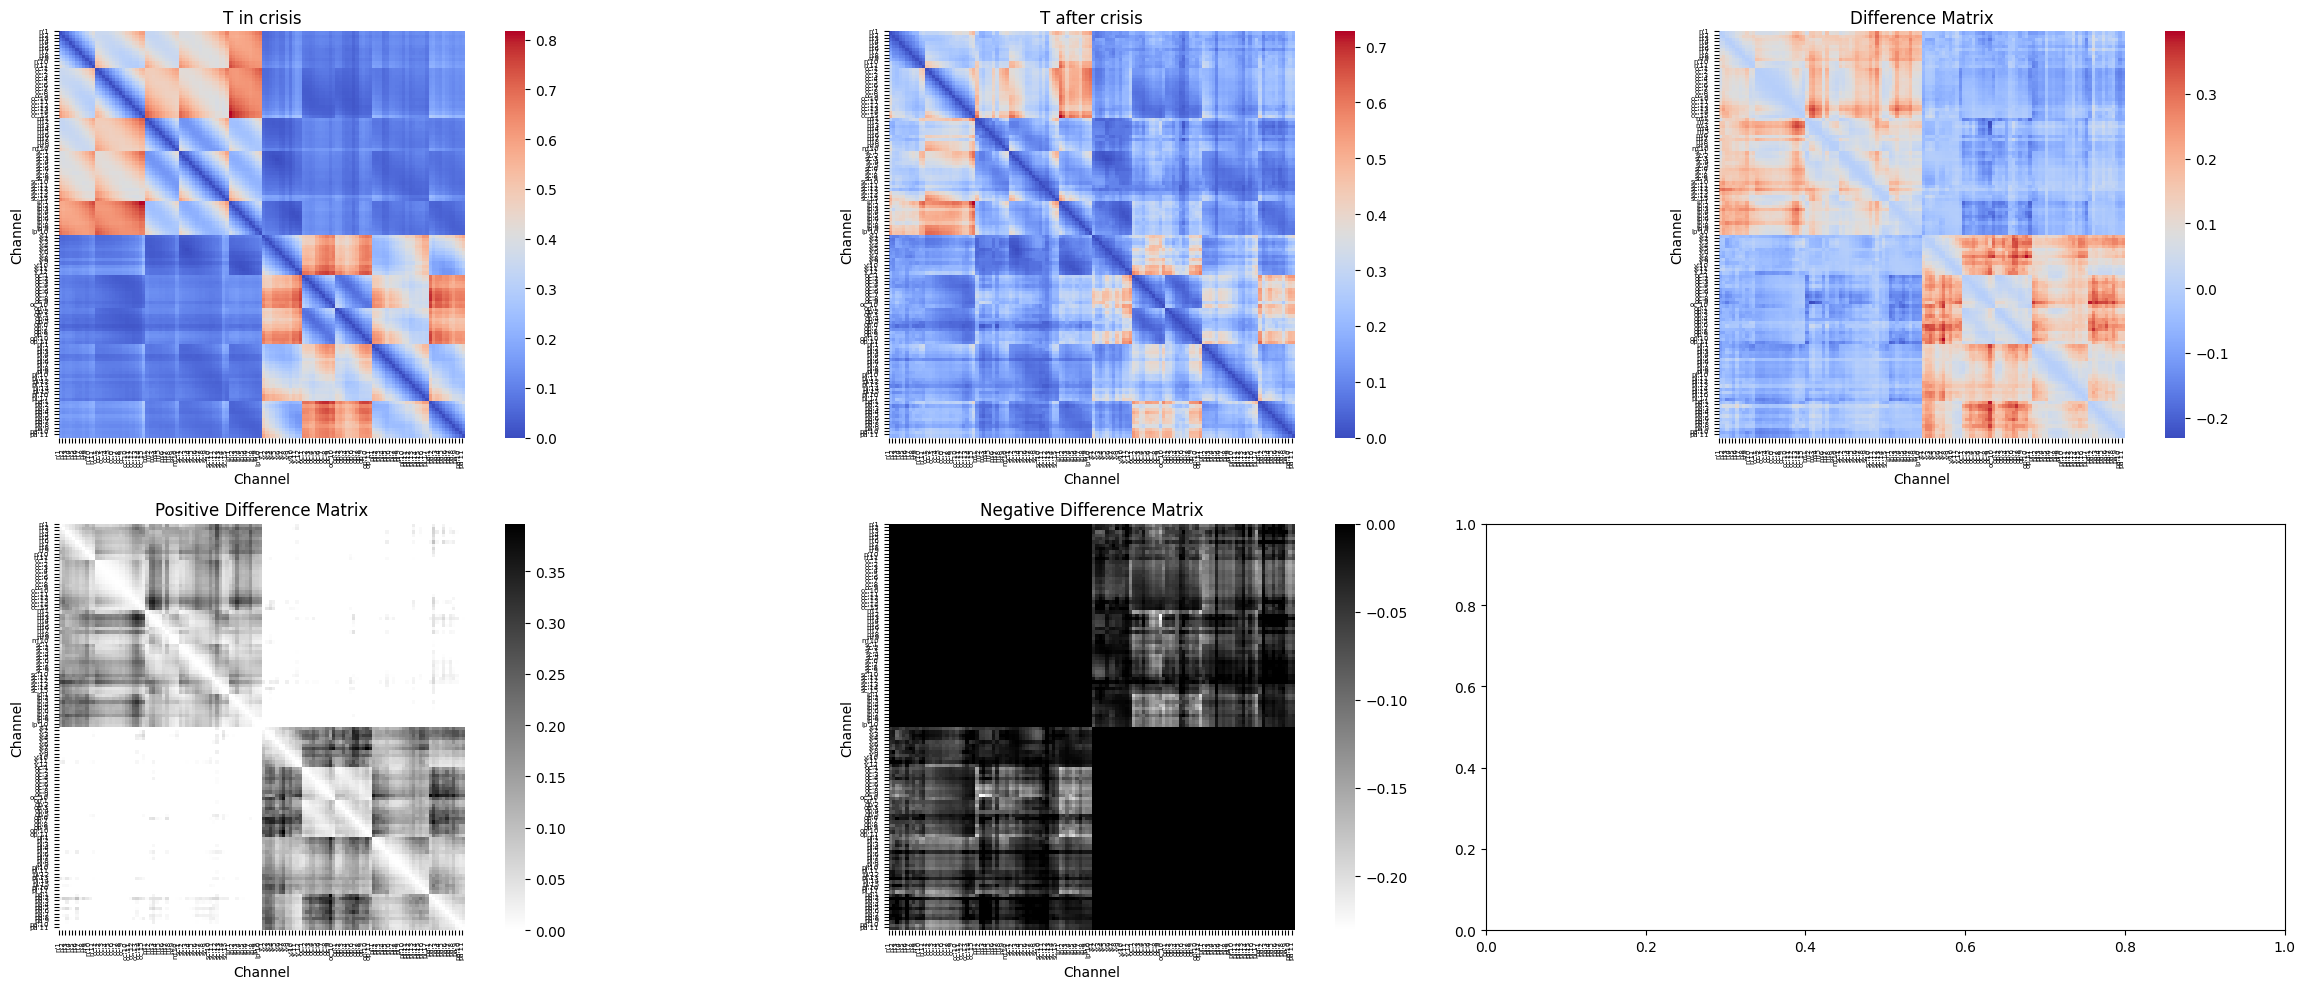

In [250]:
# Difference matrix 
# Get the difference matrix
diff_matrix = data[30,:,:] - data[32,:,:]

#Matrix with positive values
positive_diff_matrix=diff_matrix.copy()
positive_diff_matrix[positive_diff_matrix<0]=0

#Matrix with negative values
negative_diff_matrix=diff_matrix.copy()
negative_diff_matrix[negative_diff_matrix>0]=0


# Plot the difference matrix and the original matrix
fig, axs = plt.subplots(2, 3, figsize=(25, 10))

# Plot the original matrix
sns.heatmap(data[30,:,:], cmap='coolwarm', square=True, ax=axs[0,0])
#Channels names 
axs[0,0].set_yticks(range(len(ch_names)))
axs[0,0].set_yticklabels(ch_names, rotation=0)
axs[0,0].set_xticks(range(len(ch_names)))
axs[0,0].set_xticklabels(ch_names, rotation=90)
#Size fo the axis labels
axs[0,0].tick_params(axis='both', which='major', labelsize=5)

axs[0,0].set_title("T in crisis")
axs[0,0].set_xlabel("Channel")
axs[0,0].set_ylabel("Channel")


sns.heatmap(data[32,:,:], cmap='coolwarm', square=True, ax=axs[0,1])
axs[0,1].set_yticks(range(len(ch_names)))
axs[0,1].set_yticklabels(ch_names, rotation=0)
axs[0,1].set_xticks(range(len(ch_names)))
axs[0,1].set_xticklabels(ch_names, rotation=90)
axs[0,1].tick_params(axis='both', which='major', labelsize=5)


axs[0,1].set_title("T after crisis")
axs[0,1].set_xlabel("Channel")
axs[0,1].set_ylabel("Channel")

# Plot the difference matrix
sns.heatmap(diff_matrix, cmap='coolwarm', square=True, ax=axs[0,2])
axs[0,2].set_yticks(range(len(ch_names)))
axs[0,2].set_yticklabels(ch_names, rotation=0)
axs[0,2].set_xticks(range(len(ch_names)))
axs[0,2].set_xticklabels(ch_names, rotation=90)
axs[0,2].tick_params(axis='both', which='major', labelsize=5)


axs[0,2].set_title("Difference Matrix")
axs[0,2].set_xlabel("Channel")
axs[0,2].set_ylabel("Channel")

# Plot the positive difference matrix
sns.heatmap(positive_diff_matrix, cmap='binary', square=True, ax=axs[1,0])
axs[1,0].set_yticks(range(len(ch_names)))
axs[1,0].set_yticklabels(ch_names, rotation=0)
axs[1,0].set_xticks(range(len(ch_names)))
axs[1,0].set_xticklabels(ch_names, rotation=90)
axs[1,0].tick_params(axis='both', which='major', labelsize=5)


axs[1,0].set_title("Positive Difference Matrix")
axs[1,0].set_xlabel("Channel")
axs[1,0].set_ylabel("Channel")


# Plot the negative difference matrix
sns.heatmap(negative_diff_matrix, cmap='binary', square=True, ax=axs[1,1])
axs[1,1].set_yticks(range(len(ch_names)))
axs[1,1].set_yticklabels(ch_names, rotation=0)
axs[1,1].set_xticks(range(len(ch_names)))
axs[1,1].set_xticklabels(ch_names, rotation=90)
axs[1,1].tick_params(axis='both', which='major', labelsize=5)


axs[1,1].set_title("Negative Difference Matrix")
axs[1,1].set_xlabel("Channel")
axs[1,1].set_ylabel("Channel")



plt.tight_layout()
plt.show()



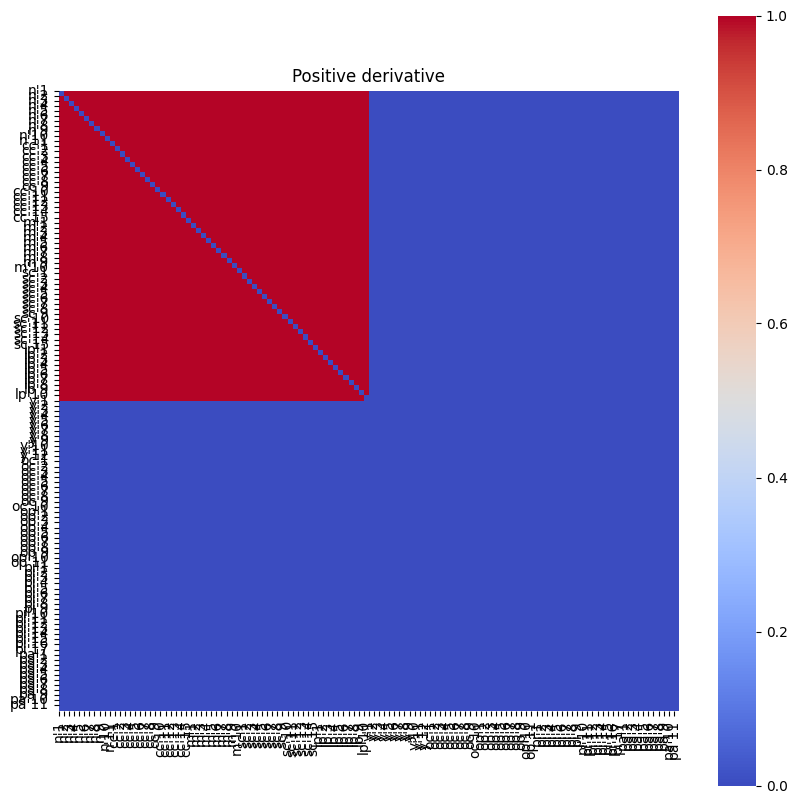

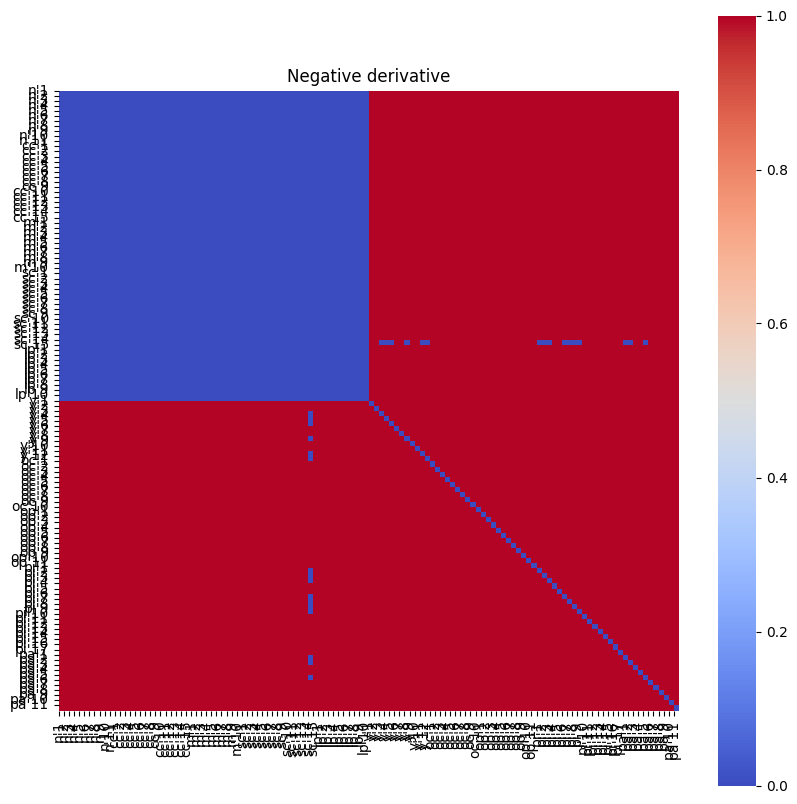

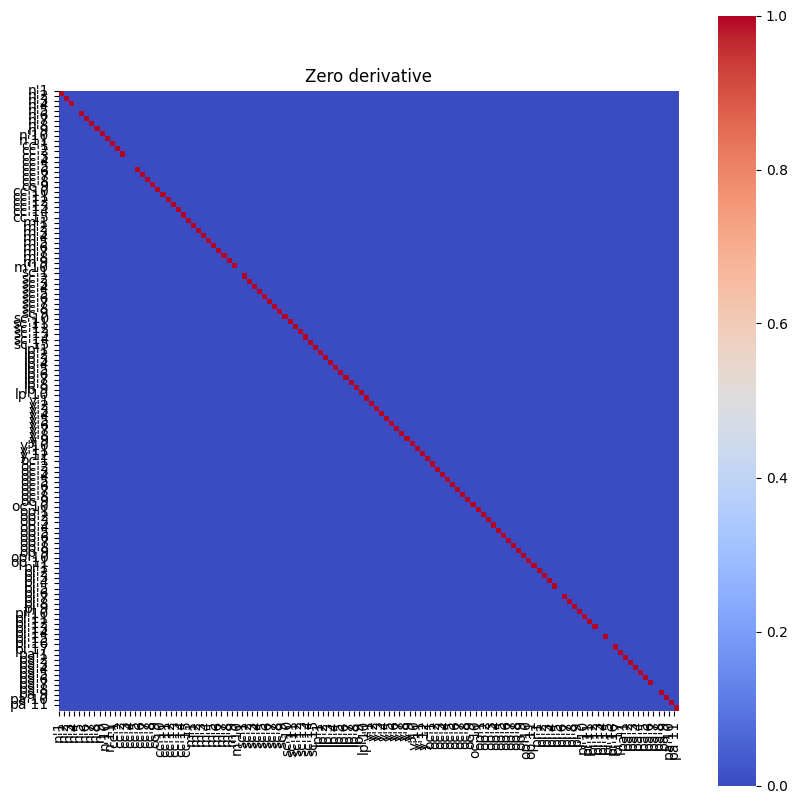

In [273]:
m_pos=np.zeros((len(ch_names),len(ch_names)))
m_neg=np.zeros((len(ch_names),len(ch_names)))
m_zero=np.zeros((len(ch_names),len(ch_names)))

for key in pos_dict.keys():
    for ch in pos_dict[key]:
        m_pos[ch_names.index(key),ch_names.index(ch)]=1

for key in neg_dict.keys():
    for ch in neg_dict[key]:
        m_neg[ch_names.index(key),ch_names.index(ch)]=1

for key in zero_dict.keys():
    for ch in zero_dict[key]:
        m_zero[ch_names.index(key),ch_names.index(ch)]=1
    
#plot m_pos 
plt.figure(figsize=(10,10))
sns.heatmap(m_pos, cmap='coolwarm', square=True)
#Channels names
plt.yticks(range(len(ch_names)),ch_names, rotation=0)
plt.xticks(range(len(ch_names)),ch_names, rotation=90)
plt.title('Positive derivative')
plt.show()

#plot m_neg
plt.figure(figsize=(10,10))
sns.heatmap(m_neg, cmap='coolwarm', square=True)
#Channels names
plt.yticks(range(len(ch_names)),ch_names, rotation=0)
plt.xticks(range(len(ch_names)),ch_names, rotation=90)
plt.title('Negative derivative')
plt.show()

#plot m_zero
plt.figure(figsize=(10,10))
sns.heatmap(m_zero, cmap='coolwarm', square=True)
#Channels names
plt.yticks(range(len(ch_names)),ch_names, rotation=0)
plt.xticks(range(len(ch_names)),ch_names, rotation=90)
plt.title('Zero derivative')
plt.show()
